###### Курсовой проект для курса "Python для Data Science"

###### Материалы к проекту (файлы): train.csv test.csv

## Задание: 
> Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
> С помощью полученной модели предсказать цены для квартир из файла test.csv.

##### Целевая переменная: 
* Price

##### Основная метрика: 
* R2 - коэффициент детерминации (sklearn.metrics.r2_score)

##### Вспомогательная метрика: 
* MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

## Сдача проекта: 
>1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). 
>2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

##### Сроки сдачи: 
* Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

##### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#####  Подключаем библиотеки.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import gmtime

In [2]:
SOURCE_TRAIN_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/train.csv'
SOURCE_TEST_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/test.csv'
df_train = pd.read_csv(SOURCE_TRAIN_CSV)
df_test = pd.read_csv(SOURCE_TEST_CSV)
filename = 'DmitriyIvanov_pred.csv'

##### Функция межквартильного размаха.

In [3]:
def ir(name):
    a = df_train.loc[df_train[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

def irt(name):
    a = df_test.loc[df_test[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

##### Функция графика (повзаимствованная)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

##### Удалим дубликаты, если таковые имеются.

In [5]:
df_train.drop_duplicates();

##### Установим поле id как индекс и переупорядочим его.

In [6]:
#df_train = df_train.set_index('Id')
#df_train.reset_index(inplace = True, drop = True)
#df_train.index.name = 'id'

##### Проверим наш датасет на null значения.

In [7]:
df_train.isnull().any();

##### Приведем некоторые типы к целым значениям

In [8]:
df_train['Rooms'] = df_train['Rooms'].astype(int)

df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)

x_min_year = ir('HouseYear')[0]

x_max_year = gmtime().tm_year

##### Поправим год строительства

In [9]:
year_median = df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()

In [10]:
df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median

In [11]:
df_train['HouseYear'] = df_train['HouseYear'].astype(int)

In [12]:
df_train['HouseYear'].describe()

count    10000.000000
mean      1984.639100
std         17.743994
min       1934.000000
25%       1974.000000
50%       1977.000000
75%       1999.250000
max       2018.000000
Name: HouseYear, dtype: float64

##### Поправим этажность домов

In [13]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = random.randint(1,df_train['HouseFloor'].median())

In [14]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor'] = random.randint(1,df_train['HouseFloor'].median())

##### Поправим этаж квартир

In [15]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}] = df_train['HouseFloor'].apply(lambda x: random.randint(1, x))

##### Проверим, что нет больше квартир находящихся за пределом этажности дома

In [16]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], {'Floor'}]

,Floor


##### Поправим выбросы по комнатам 

In [17]:
df_train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

##### Для начала вычислим медианное значение кол-ва комнат по району и году постройки

In [18]:
filter1 = df_train.loc[~((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]

filter1 = filter1.groupby(['DistrictId','HouseYear']).median()

In [19]:
a = df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]

b = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')

##### Вычислили медианное значение для комнат такого типа

In [20]:
b['Rooms_y'].median()

2.0

##### Проверим, что нет null значений

In [21]:
df_train['Rooms'].isnull().any()

False

##### Изменим неправильные начения на медианные

In [22]:
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6), 'Rooms'] = b['Rooms_y'].median()

In [23]:
df_train[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


##### Разберемся с площадью кухни

In [24]:
x_min_ksquare = ir('KitchenSquare')[0]

x_max_ksquare = ir('KitchenSquare')[1]

x_med_ksquare = df_train['KitchenSquare'].median()

##### Поправим большие значения выходящие за максимальный размах более чем в 2 раза. В нашем случаее размах = 22

In [25]:
df_train.loc[df_train['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare

##### Посмотрим на площадь кухонь менее 5 метров. Логично пердположить, что таких должно быть немного, но картина другая

In [26]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'].value_counts()

1.0    2460
0.0     697
4.0      39
3.0      22
2.0       4
Name: KitchenSquare, dtype: int64

##### Поправим все кухни менее 5 метров на медианное значение

In [27]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquare

In [28]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         7.416600
std          2.373817
min          5.000000
25%          6.000000
50%          6.000000
75%          9.000000
max         22.000000
Name: KitchenSquare, dtype: float64

##### Healthcare_1 Заполним пустые значения медианными и заполним значения которые выходят за размах

In [29]:
x_min_h1 = ir('Healthcare_1')[0]

x_max_h1 = ir('Healthcare_1')[1]

h1_median = df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()

In [30]:
df_train.loc[df_train['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [31]:
df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median

In [32]:
df_train['Healthcare_1'].median()

900.0

##### Healthcare_2 распределение выглядит  нормальным, менять не будем

In [33]:
df_train['Helthcare_2'].sort_values().value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

##### Заполним пустые значения жилой площади

In [34]:
med_dif = df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}].median()['Square']-\
df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}].median()['LifeSquare']

df_train.loc[df_train['LifeSquare'].isnull(),'LifeSquare'] = df_train['Square'] - med_dif

##### Пересчитаем значения для некорректной жилой площади

In [35]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square'] + df_train['KitchenSquare']),'LifeSquare'] =\
df_train['Square'] - df_train['KitchenSquare']

##### Исправим выбросы для общей площади

In [36]:
s25 = df_train['Square'].quantile(.25) 

s75 = df_train['Square'].quantile(.75)

sdiff = s75 - s25

smax = s75 + 1.5*sdiff

smin = s25 - 1.5*sdiff

df_train.loc[df_train['Square']> smax, 'Square'] = df_train[df_train['Square']> smax].median()['Square']

In [37]:
df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'Square'] = df_train[df_train['LifeSquare'] > df_train['Square']]['LifeSquare']

##### Экология и Магазины

In [38]:
df_train['E_2'] = df_train['Ecology_2'].replace({'A':2, 'B':1})

df_train['E_3'] = df_train['Ecology_3'].replace({'A':2, 'B':1})

df_train['S_2'] = df_train['Shops_2'].replace({'A':2, 'B':1})

##### Удалим явно неправильные данные

In [39]:
p25 = df_train['Price'].quantile(.25) 

p75 = df_train['Price'].quantile(.75)

pdiff = p75 - p25

pmax = p75 + 1.5*pdiff

pmin = p25 - 1.5*pdiff

df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)

df_train[(df_train['Square'] < smin)] = df_train['Square'].median()

##### Была идея расчитать медианную цену за 1 метр квадратный по району, но медианная цена с учетом площади, этажа и кол-ва комнат показала себя лучше

In [40]:
df_train['Square_round'] = (round(df_train['Square'].astype(int)/10)*10).astype(int)

In [41]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

##### Введем еще один категориальный признак размер района, но возможно от него стоит отказаться, т.к. этот признак влияет не существенно.

In [42]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_train = df_train.merge(district_size, on='DistrictId', how='left')

df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > df_train['DistrictSize'].median()).astype(int)

##### Добавим наши новые признаки в датасет

In [43]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

##### Запишем список фичей в переменные

In [44]:
feature_names = ['Id','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'E_2', 'E_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'S_2', 'Square_round']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

##### Определим датафреймы для нашей модели

In [45]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


In [48]:
#df_train = df_train.drop('Square_round_y', axis=1)

#df_train = df_train.rename(columns={'Square_round_x':'Square_round'})

In [49]:
X = df_train[feature_names + new_feature_names]
y = df_train[target_name]

##### Проверим isnull значение еще раз

In [50]:
df_train.isnull().any()

Id                    False
DistrictId            False
Rooms                 False
Square                False
LifeSquare            False
KitchenSquare         False
Floor                 False
HouseFloor            False
HouseYear             False
Ecology_1             False
Ecology_2             False
Ecology_3             False
Social_1              False
Social_2              False
Social_3              False
Healthcare_1          False
Helthcare_2           False
Shops_1               False
Shops_2               False
Price                 False
E_2                   False
E_3                   False
S_2                   False
Square_round          False
DistrictSize          False
IsDistrictLarge       False
MedPriceByDistrict    False
dtype: bool

##### Посмотрим описание нашего датасета

In [51]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8372.970752,50.428752,1.945152,56.409483,37.488348,7.467852,7.000852,12.098052,1982.514952,0.176599,...,1.376252,4.285452,213833.899053,1.066452,1.084252,1.139252,55.957000,241.374800,0.495700,211228.725313
std,4864.682041,43.573390,1.866497,20.660731,20.370537,2.806306,5.352020,7.125405,66.457599,1.743551,...,2.262128,5.065002,92989.304650,1.712762,1.717170,1.729562,21.195497,267.985598,0.500007,76839.724561
min,0.000000,0.000000,1.000000,5.610772,-0.677206,5.000000,1.000000,1.000000,52.592594,0.000000,...,0.000000,0.000000,52.592594,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,52.592594
25%,4154.750000,20.000000,1.000000,41.883697,23.446803,6.000000,3.000000,5.000000,1974.000000,0.017647,...,0.000000,1.000000,153781.674885,1.000000,1.000000,1.000000,40.000000,55.000000,0.000000,165071.825722
50%,8387.500000,36.000000,2.000000,52.596224,33.544682,6.000000,6.000000,12.000000,1977.000000,0.075424,...,1.000000,3.000000,192133.221510,1.000000,1.000000,1.000000,50.000000,104.000000,0.000000,195474.299127
75%,12589.250000,75.000000,2.000000,65.985903,46.448656,9.000000,10.000000,17.000000,1999.000000,0.195781,...,2.000000,6.000000,249067.022116,1.000000,1.000000,1.000000,60.000000,510.000000,1.000000,241068.903045
max,16798.000000,209.000000,52.592594,638.163193,638.163193,52.592594,52.592594,117.000000,2018.000000,52.592594,...,52.592594,52.592594,633233.466570,52.592594,52.592594,52.592594,640.000000,848.000000,1.000000,624156.003381


##### Обнаружены еще выбросы которые мы не поправили 

In [52]:
df_train.loc[(df_train['LifeSquare'] < 9),'LifeSquare'] = (df_train['Square'].median() - df_train['KitchenSquare'].median())

##### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ___ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

##### Обучим нашу модель и посмотрим результаты. Подобрав гипер-параметр глубины дерева остановился на 11, т.к. данное значение показывает наилучший score на кросс-валидационной проверке

Train R2:	0.953
Test R2:	0.744


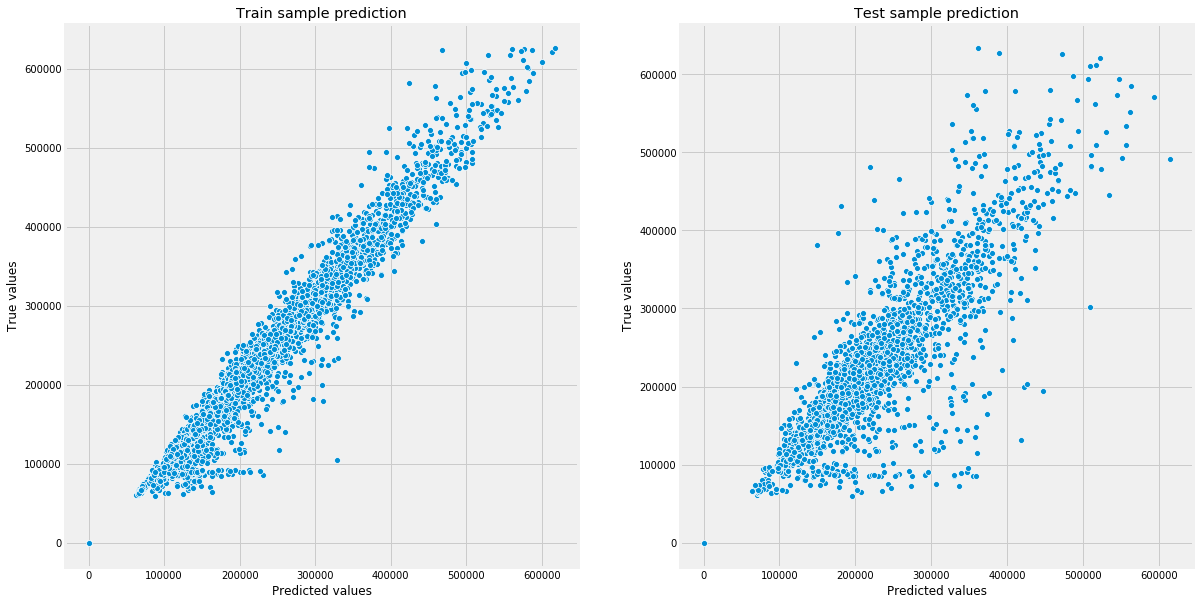

In [53]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, oob_score = True, max_depth = 17, n_estimators = 21)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

##### Кросс валидация, считаю, что 6 разбиений показвает лучше качество нашей модели чем 3 по умолчание

In [54]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=21))
cv_score.mean()

0.7477701681543708

* 0.9999959605613693 - лучший результат, но мое мнение это уже предел погрешности

##### Важность фичей, как и следовало предположить наша гипер-фича имеет топ 1

In [55]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
20,MedPriceByDistrict,0.621416
2,Square,0.112346
3,LifeSquare,0.028635
13,Social_3,0.027828
4,KitchenSquare,0.026819
7,HouseYear,0.025599
0,Id,0.023145
12,Social_2,0.021529
6,HouseFloor,0.018924
5,Floor,0.017208


In [56]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


### Прогнозирование на тестовом датасете

> 1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
> 2. Не потерять и не перемешать индексы от примеров при построении прогнозов
> 3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [57]:
df_test.head().sort_values(by = 'Id', ascending = True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


##### Применим все наши трансформации для тестового датасета

In [58]:
df_test['Rooms'] = df_test['Rooms'].astype(int)

df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)

x_min_yeart = irt('HouseYear')[0]

x_max_yeart = gmtime().tm_year

In [59]:
year_mediant = df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_max_yeart and x >= x_min_yeart),'HouseYear'].median()

In [60]:
df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_min_yeart or x >= x_max_yeart),'HouseYear'] = year_mediant

In [61]:
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

In [62]:
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = random.randint(1,df_test['HouseFloor'].median())

In [63]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor'] = df_test['HouseFloor'].median()

In [64]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], {'Floor'}] = df_test['HouseFloor'].apply(lambda x: random.randint(1, x))

In [65]:
filter1t = df_test.loc[~((df_test['Rooms'] == 0) | (df_test['Rooms'] > 6)),{'DistrictId','HouseYear','Rooms'}]

filter1t = filter1t.groupby(['DistrictId','HouseYear']).median()

In [66]:
df_test['Rooms'].value_counts()

2     2030
1     1769
3     1099
4       90
5        7
6        2
0        2
17       1
Name: Rooms, dtype: int64

In [67]:
a = df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]

b = pd.merge(a, filter1t, on=['DistrictId','HouseYear'],how='left')

In [68]:
df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6), 'Rooms'] = b['Rooms_y'].median()

In [69]:
x_min_ksquaret = irt('KitchenSquare')[0]

x_max_ksquaret = irt('KitchenSquare')[1]

x_med_ksquaret = df_test['KitchenSquare'].median()

In [70]:
df_test.loc[df_test['KitchenSquare'] > x_max_ksquaret, 'KitchenSquare'] = x_max_ksquaret

In [71]:
df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'] = x_med_ksquaret

In [72]:
x_min_h1t = irt('Healthcare_1')[0]

x_max_h1t = irt('Healthcare_1')[1]

h1_mediant = df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_max_h1t and x >= x_min_h1t),'Healthcare_1'].median()

In [73]:
df_test.loc[df_test['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [74]:
df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_min_h1t or x >= x_max_h1t),'Healthcare_1'] = h1_mediant

In [75]:
med_dift = df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}].median()['Square']-\
df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}].median()['LifeSquare']

df_test.loc[df_test['LifeSquare'].isnull(),'LifeSquare'] = df_test['Square'] - med_dift

In [76]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square'] + df_test['KitchenSquare']),'LifeSquare'] =\
df_test['Square'] - df_test['KitchenSquare']

In [77]:
s25t = df_test['Square'].quantile(.25) 

s75t = df_test['Square'].quantile(.75)

sdifft = s75t - s25t

smaxt = s75t + 1.5*sdifft

smint = s25t - 1.5*sdifft

df_test.loc[df_test['Square']> smaxt, 'Square'] = df_test[df_test['Square']> smaxt].median()['Square']

In [78]:
df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'Square'] = df_test[df_test['LifeSquare'] > df_test['Square']]['LifeSquare']

In [79]:

df_test['E_2'] = df_test['Ecology_2'].replace({'A':2, 'B':1})

df_test['E_3'] = df_test['Ecology_3'].replace({'A':2, 'B':1})

df_test['S_2'] = df_test['Shops_2'].replace({'A':2, 'B':1})

In [80]:
df_test['Square_round'] = (round(df_test['Square'].astype(int)/10)*10).astype(int)

##### У нас образовались некотрые пробелы в заполнении признака MedPriceByDistrict заполним их

In [84]:
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0.0,1.0,142799.434052
1,0.0,2.0,176210.812334
2,0.0,3.0,300610.359425
3,1.0,1.0,146574.015522
4,1.0,2.0,202666.310126


In [85]:
m = med_price_by_district.groupby(['DistrictId','Rooms']).median()

df_test = df_test.merge(m, on = ['DistrictId','Rooms'], how='left')

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,87,810.0,5,5,B,1,1,1,20,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,2,50,118346.848790


In [ ]:
#test_gap = df_test[(df_test['MedPriceByDistrict'].isnull())]

In [ ]:
#med_train = df_train.groupby(['DistrictId']).median()['MedPriceByDistrict']/df_train.groupby(['DistrictId']).median()['Square']
#med_train = pd.DataFrame(med_train,columns=['pp1m'])

In [ ]:
#test_gap.head()

In [ ]:
#test_gap = test_gap.merge(med_train, on = ['DistrictId'], how='left')
#test_gap2 = test_gap[(test_gap['MedPriceByDistrict'].isnull())]

In [ ]:
#test_gap.loc[test_gap['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_gap2['Square'] * med_train['pp1m'].median()

In [86]:
df_test.loc[df_test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = df_test['MedPriceByDistrict'].median()

In [87]:
df_test = df_test.rename(columns={'Square_x':'Square'})

In [88]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,B,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,3,900.0,0,2,B,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,87,810.0,5,5,B,1,1,1,20,197049.231078
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,B,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,2,50,118346.848790


##### Удалим ненужные колонки

In [89]:
#df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
df_test = df_test.drop('Shops_2', axis=1)

In [ ]:
#df_test = df_test.drop('HouseYear_y', axis=1)

In [ ]:
#df_test = df_test.drop('Floor_y', axis=1)

In [90]:
df_test = df_test.drop('Ecology_2', axis=1)

In [91]:
df_test = df_test.drop('Ecology_3', axis=1)

##### Проверим что нет null значений

In [92]:
df_test.isnull().any()

Id                    False
DistrictId            False
Rooms                 False
Square                False
LifeSquare            False
KitchenSquare         False
Floor                 False
HouseFloor            False
HouseYear             False
Ecology_1             False
Social_1              False
Social_2              False
Social_3              False
Healthcare_1          False
Helthcare_2           False
Shops_1               False
E_2                   False
E_3                   False
S_2                   False
Square_round          False
MedPriceByDistrict    False
dtype: bool

##### Сделаем предсказания цен

In [93]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,E_2,E_3,S_2,Square_round,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,1,1,1,50,166809.665642
1,15856,74,2.0,69.263183,51.212797,6.0,6,12.0,1977,0.075779,...,1437,3,900.0,0,2,1,1,1,70,243031.695525
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1977,0.000000,...,7538,87,810.0,5,5,1,1,1,20,197049.231078
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,1,1,1,70,222227.584211
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,1,1,2,50,118346.848790


In [94]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,E_2,E_3,S_2,Square_round,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038.0,35.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,...,11.0,B,184966.930730,1.0,1.0,1.0,50,22,0,207786.135836
1,15053.0,41.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,...,16.0,B,300009.450063,1.0,1.0,1.0,60,87,0,300009.450063
2,4765.0,53.0,2.0,44.947953,29.197612,6.0,8.0,12.0,1968.0,0.049637,...,3.0,B,220925.908524,1.0,1.0,1.0,40,174,1,263206.223152
3,5809.0,58.0,2.0,53.352981,52.731512,9.0,8.0,17.0,1977.0,0.437885,...,5.0,B,175616.227217,1.0,1.0,1.0,50,179,1,166809.665642
4,10783.0,99.0,1.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,...,4.0,B,150226.531644,1.0,1.0,1.0,40,97,0,158539.052715


In [95]:
a = rf_model.predict(df_test)

In [96]:
a = pd.DataFrame(a,columns=['Price'])
a.head()

,Price
0,139779.332563
1,191035.947130
2,198202.909424
3,211649.562232
4,57371.670676


##### Проверим длинну нашего датафрейма

In [97]:
len(a)

5000

##### объединим нужные колонки и выгрузим в файл

In [98]:
result = pd.concat([df_test['Id'].astype(int) , a['Price']], axis=1, sort=False)

result.to_csv(filename,index=False,encoding='utf-8')

In [99]:
a.head()

,Price
0,139779.332563
1,191035.947130
2,198202.909424
3,211649.562232
4,57371.670676
